In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [7]:
# Load and preprocess data
def load_and_preprocess_data(folder):
    dfs = []
    for i in range(9, 16):
        file_name = f"HTOL-{i:02d}_alerts.csv"
        df = pd.read_csv(os.path.join(folder, file_name))
        df['machine_id'] = f'HTOL-{i:02d}'
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df['Time'] = pd.to_datetime(combined_df['Time'])
    combined_df = combined_df.sort_values(['machine_id', 'Time'])

    return combined_df

In [8]:

# Feature engineering
def engineer_features(df):
    df['hour'] = df['Time'].dt.hour
    df['day_of_week'] = df['Time'].dt.dayofweek
    df['month'] = df['Time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Calculate rolling statistics
    df['rolling_mean'] = df.groupby('machine_id')['ChlPrs'].rolling(window=24, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_std'] = df.groupby('machine_id')['ChlPrs'].rolling(window=24, min_periods=1).std().reset_index(0, drop=True)

    # Calculate time since last alert for each type
    alert_types = ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']
    for alert_type in alert_types:
        df[f'time_since_{alert_type}'] = df.groupby('machine_id').apply(lambda x: x['Time'] - x[x['ALERT'] == alert_type]['Time'].shift(1)).reset_index(level=0, drop=True)
        df[f'time_since_{alert_type}'] = df[f'time_since_{alert_type}'].dt.total_seconds() / 3600  # Convert to hours

    return df

In [9]:

# Prepare data for model training
def prepare_data_for_model(df, target_alert_type, prediction_horizon):
    df['target'] = df.groupby('machine_id').apply(lambda x: x[x['ALERT'] == target_alert_type]['Time'].shift(-1) - x['Time']).reset_index(level=0, drop=True)
    df['target'] = df['target'].dt.total_seconds() / (24 * 3600)  # Convert to days

    # Remove rows where target is greater than the prediction horizon
    df = df[df['target'] <= prediction_horizon]

    # Remove rows with NaN targets (i.e., last occurrence of each alert type for each machine)
    df = df.dropna(subset=['target'])

    features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']]
    X = df[features]
    y = df['target']

    return X, y

In [12]:

# Train and evaluate model
def train_and_evaluate_model(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Mean Absolute Error: {mae:.2f} days")
    print(f"Root Mean Squared Error: {rmse:.2f} days")

    return model, scaler

In [13]:

# Visualize actual and predicted alerts
def visualize_alerts(df, model, scaler, target_alert_type, prediction_horizon):
    features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']]
    X = df[features]
    X_scaled = scaler.transform(X)

    df['predicted_days_to_alert'] = model.predict(X_scaled)
    df['predicted_alert_date'] = df['Time'] + pd.to_timedelta(df['predicted_days_to_alert'], unit='D')

    plt.figure(figsize=(20, 10))
    for machine_id in df['machine_id'].unique():
        machine_df = df[df['machine_id'] == machine_id]

        # Plot actual alerts
        alerts = machine_df[machine_df['ALERT'] == target_alert_type]
        plt.scatter(alerts['Time'], [machine_id] * len(alerts), marker='o', s=100, label=f'Actual {target_alert_type} Alert')

        # Plot predicted alerts
        predicted_alerts = machine_df[machine_df['predicted_days_to_alert'] <= prediction_horizon]
        plt.scatter(predicted_alerts['predicted_alert_date'], [machine_id] * len(predicted_alerts), marker='x', s=100, label=f'Predicted {target_alert_type} Alert')

    plt.xlabel('Date')
    plt.ylabel('Machine ID')
    plt.title(f'Actual vs Predicted {target_alert_type} Alerts')
    plt.legend()
    plt.grid(True)
    plt.show()

/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_17998/670758071.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'time_since_{alert_type}'] = df.groupby('machine_id').apply(lambda x: x['Time'] - x[x['ALERT'] == alert_type]['Time'].shift(1)).reset_index(level=0, drop=True)
/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_17998/670758071.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w


Training model for LOW alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_17998/3173276234.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: x[x['ALERT'] == target_alert_type]['Time'].shift(-1) - x['Time']).reset_index(level=0, drop=True)
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/artemmosnin/op

Mean Absolute Error: 2.35 days
Root Mean Squared Error: 5.31 days


/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


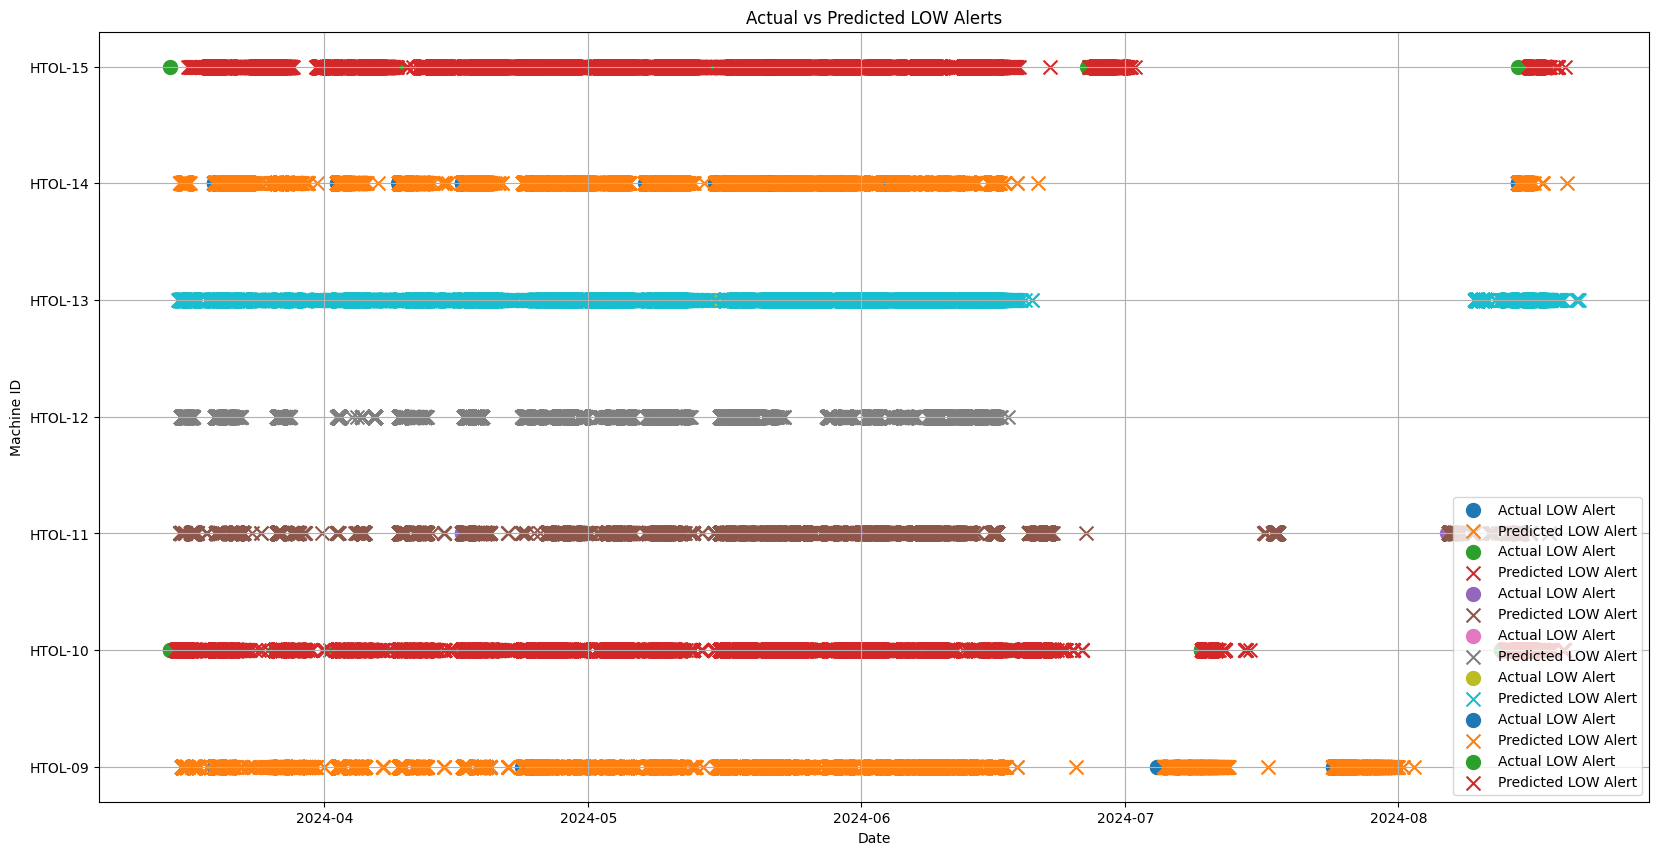


Training model for MEDIUM alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_17998/3173276234.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: x[x['ALERT'] == target_alert_type]['Time'].shift(-1) - x['Time']).reset_index(level=0, drop=True)
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/artemmosnin/op

Mean Absolute Error: 1.96 days
Root Mean Squared Error: 2.41 days


/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


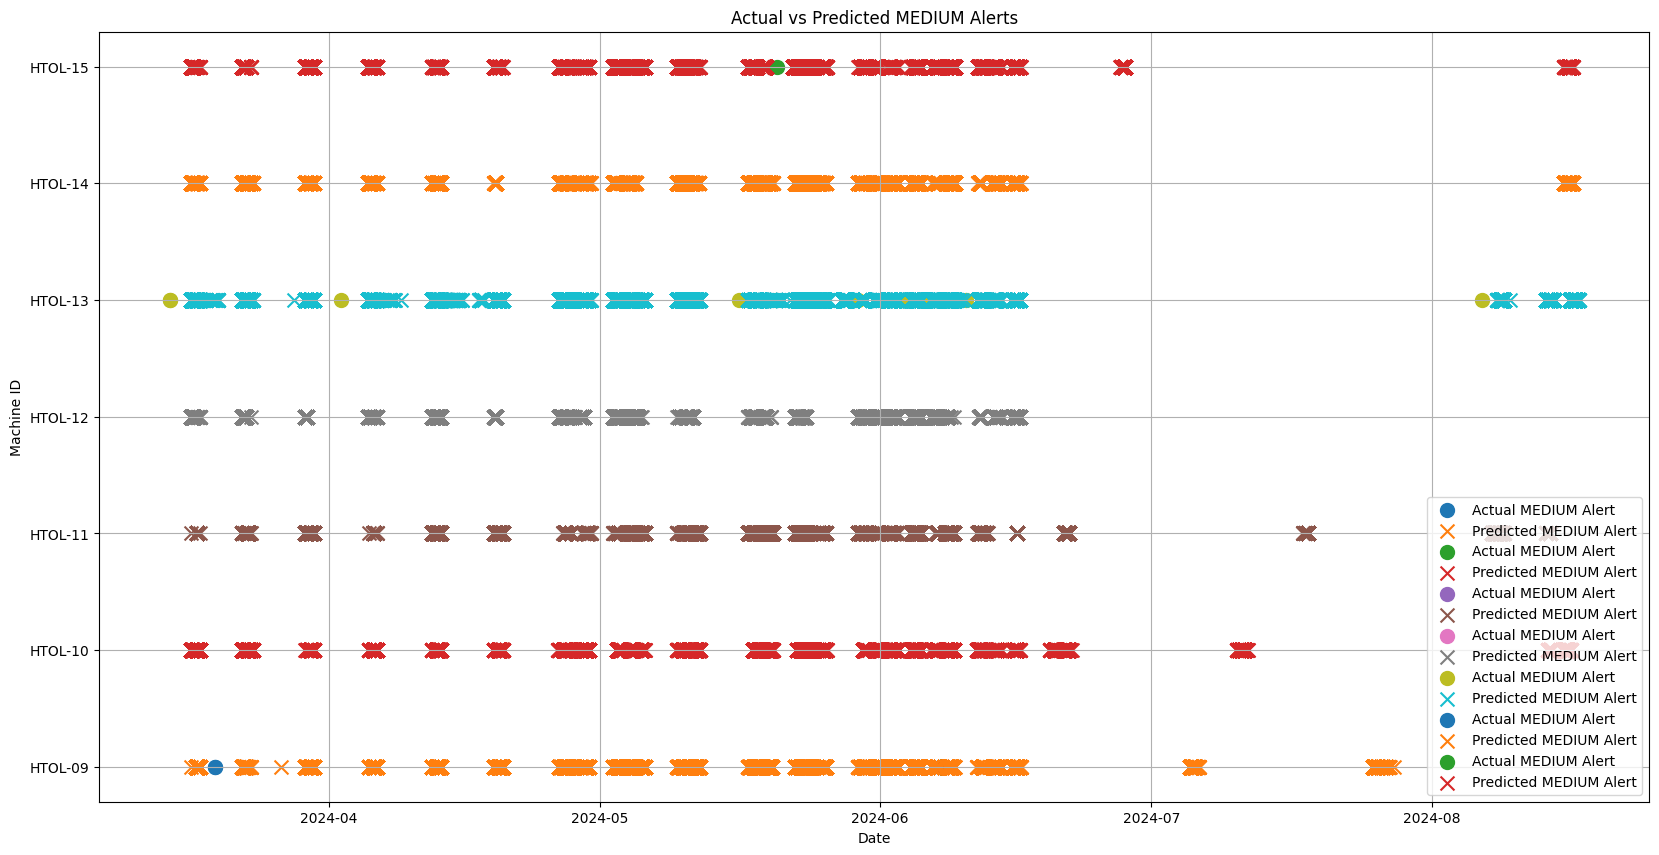


Training model for HIGH alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_17998/3173276234.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: x[x['ALERT'] == target_alert_type]['Time'].shift(-1) - x['Time']).reset_index(level=0, drop=True)
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/artemmosnin/op

Mean Absolute Error: 2.53 days
Root Mean Squared Error: 2.53 days


/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


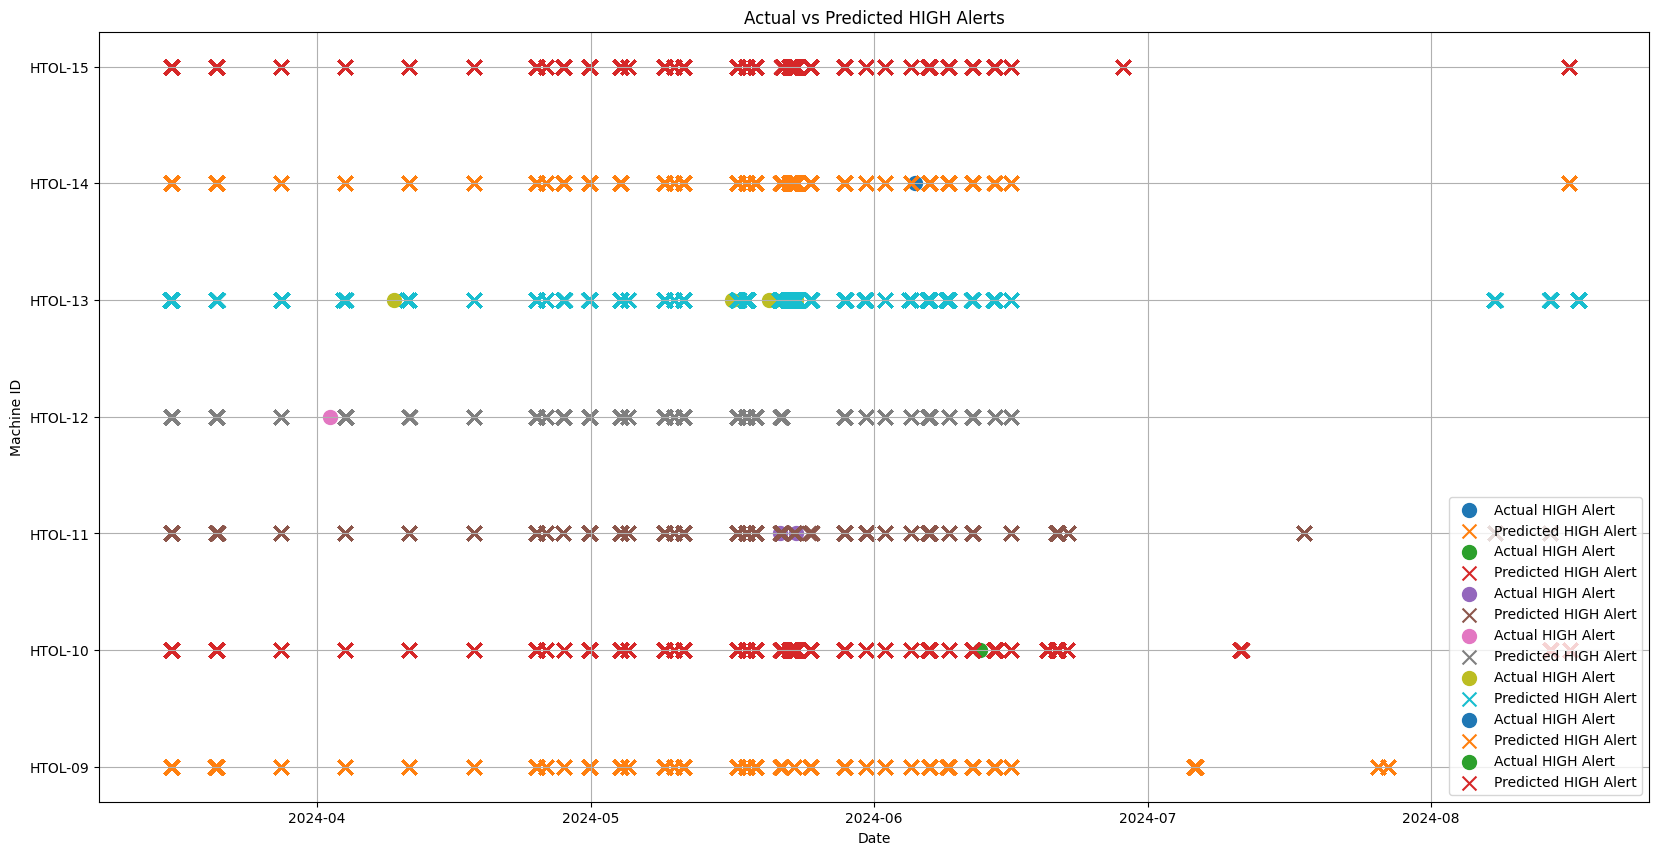


Training model for SIGMA alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_17998/3173276234.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: x[x['ALERT'] == target_alert_type]['Time'].shift(-1) - x['Time']).reset_index(level=0, drop=True)
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/artemmosnin/op

Mean Absolute Error: 3.15 days
Root Mean Squared Error: 3.23 days


/Users/artemmosnin/opt/anaconda3/envs/amd/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


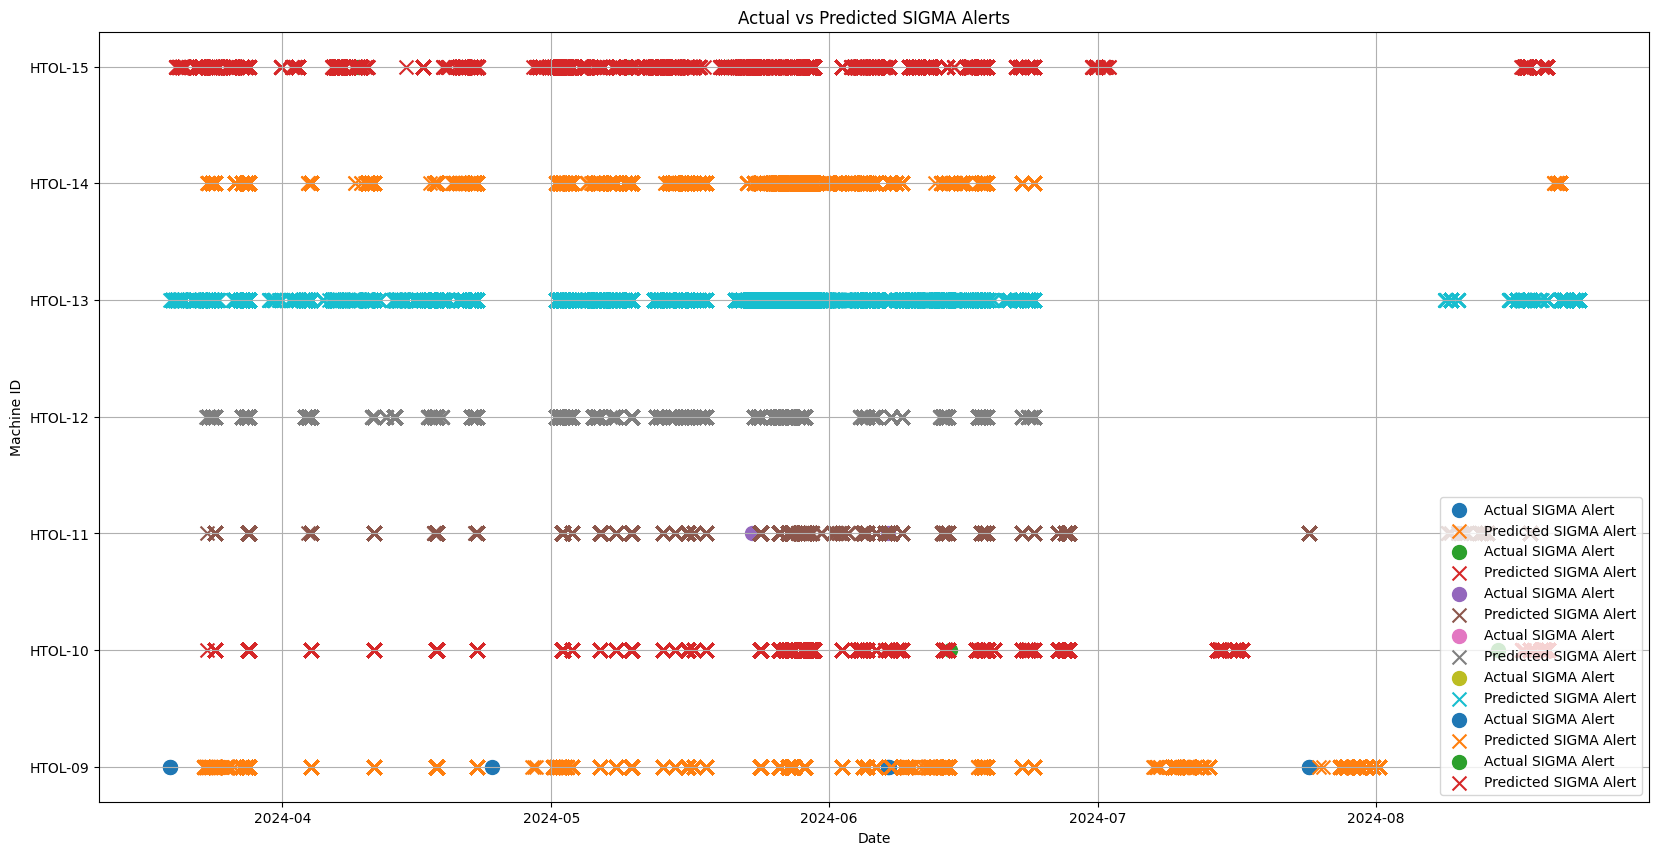

Predicted days until next LOW alert: 2.21
Predicted days until next MEDIUM alert: 1.66
Predicted days until next HIGH alert: 1.52
Predicted days until next SIGMA alert: 3.70


In [14]:

# Main execution
condition = True
if condition:
    folder = "../outlier_tolerance=5_grouping_time_window=200_anomaly_threshold=6_start_date=2022-01-01_end_date=2026-01-01"
    prediction_horizon = 30  # days

    # Load and preprocess data
    df = load_and_preprocess_data(folder)
    df = engineer_features(df)

    # Train and evaluate models for each alert type
    alert_types = ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']
    models = {}
    scalers = {}

    for alert_type in alert_types:
        print(f"\nTraining model for {alert_type} alerts:")
        X, y = prepare_data_for_model(df, alert_type, prediction_horizon)
        model, scaler = train_and_evaluate_model(X, y)
        models[alert_type] = model
        scalers[alert_type] = scaler

        # Visualize actual and predicted alerts
        visualize_alerts(df, model, scaler, alert_type, prediction_horizon)

    # Example of making predictions for new data
    new_data = df.iloc[-1:].copy()  # Use the last row as an example
    for alert_type in alert_types:
        features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in alert_types]
        X_new = new_data[features]
        X_new_scaled = scalers[alert_type].transform(X_new)
        predicted_days = models[alert_type].predict(X_new_scaled)[0]
        print(f"Predicted days until next {alert_type} alert: {predicted_days:.2f}")